In [13]:
!pip install -U "transformers>=4.44.0" "datasets>=2.19.0" peft accelerate sentencepiece


In [12]:
from huggingface_hub import login
login(new_session=False)

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, PeftModel
from tqdm import tqdm
import string
from collections import Counter
from google.colab import drive

In [3]:
# ============================================================
# 1. CONFIG
# ============================================================
DATA_CSV = "/content/drive/MyDrive/NLP Project/squad2_train_kannada.csv"  

BASE_MODEL_NAME = "google/gemma-2-2b-it"  # lighter; good starting point
OUTPUT_DIR = "/content/drive/MyDrive/gemma2_lora_bilingual_qa"

# Speed/memory tradeoffs (good defaults for A100)
MAX_SEQ_LEN = 512        # 512 is plenty for SQuAD-style passages; faster than 1024
PER_DEVICE_BATCH = 8     # per-GPU batch size
GRAD_ACCUM = 2           # effective batch = 16
NUM_EPOCHS = 2           # 2 fast epochs; increase to 3 if you still have time
LEARNING_RATE = 2e-5
TEST_SIZE = 0.2
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
    bf16_available = torch.cuda.is_bf16_supported()
    print("BF16 supported:", bf16_available)
else:
    device = torch.device("cpu")
    print("Using CPU (no CUDA found)")
    bf16_available = False

Using CUDA GPU: NVIDIA A100-SXM4-80GB
BF16 supported: True


In [7]:
# ============================================================
# 2. LOAD SINGLE CSV + TRAIN/TEST SPLIT
# ============================================================

df = pd.read_csv(DATA_CSV).fillna("")
print("Full dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=SEED,
    shuffle=True,
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Full dataset shape: (130319, 14)
Columns: ['article_title', 'paragraph_index', 'context', 'question_id', 'question', 'is_impossible', 'answer_text', 'answer_start', 'plausible_answer_text', 'plausible_answer_start', 'context_kannada', 'question_kannada', 'answer_text_kannada', 'plausible_answer_text_kannada']
Train shape: (104255, 14)
Test shape: (26064, 14)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
OUTPUT_DIR = "/content/drive/MyDrive/gemma2_lora_bilingual_qa"

In [8]:
# ============================================================
# 3. BUILD TRAINING TEXTS (INSTRUCTION-STYLE, EN + KN)
# ============================================================

def build_qa_text_en(row):
    if row.get("answer_text", "") == "":
        return None
    context = row["context"]
    question = row["question"]
    answer = row["answer_text"]
    text = (
        "You are a helpful assistant that answers questions based on the given context.\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {question}\n"
        f"Answer: {answer}"
    )
    return text


def build_qa_text_kn(row):
    if row.get("answer_text_kannada", "") == "":
        return None
    context = row["context_kannada"]
    question = row["question_kannada"]
    answer = row["answer_text_kannada"]
    text = (
        "ನೀವು ಒಬ್ಬ ಸಹಾಯಕ ಸಹಾಯಕನಾಗಿದ್ದು, ನೀಡಲಾದ ಸಂದರ್ಭದ ಆಧಾರದ ಮೇಲೆ ಪ್ರಶ್ನೆಗಳಿಗೆ ಉತ್ತರಿಸುತ್ತೀರಿ.\n\n"
        f"ಸಂದರ್ಭ:\n{context}\n\n"
        f"ಪ್ರಶ್ನೆ: {question}\n"
        f"ಉತ್ತರ: {answer}"
    )
    return text


def make_training_texts(df):
    examples = []
    for _, row in df.iterrows():
        is_imp = str(row.get("is_impossible", "")).lower() == "true"
        if is_imp:
            continue

        en_text = build_qa_text_en(row)
        if en_text:
            examples.append({"text": en_text})

        kn_text = build_qa_text_kn(row)
        if kn_text:
            examples.append({"text": kn_text})
    return examples



In [9]:
train_examples = make_training_texts(train_df)
print("Num training examples (EN + KN):", len(train_examples))

eval_examples = train_examples[: max(100, int(0.05 * len(train_examples)))]
print("Num eval examples:", len(eval_examples))

Num training examples (EN + KN): 138821
Num eval examples: 6941


In [13]:
# ============================================================
# 4. DATASET + TOKENIZATION
# ============================================================

train_dataset = Dataset.from_pandas(pd.DataFrame(train_examples))
eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_examples))

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding=False,
    )

tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
)

tokenized_eval = eval_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
)

print(tokenized_train)


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Map:   0%|          | 0/138821 [00:00<?, ? examples/s]

Map:   0%|          | 0/6941 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 138821
})


In [14]:
dtype = torch.bfloat16 if bf16_available else torch.float16

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=dtype,
).to(device)

model.config.use_cache = False

# LoRA
lora_config = LoraConfig(
    r=16,                      
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()




config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

trainable params: 6,389,760 || all params: 2,620,731,648 || trainable%: 0.2438


In [18]:
# ============================================================
# 7. TRAINING ARGS – A100 & SPEED-ORIENTED
# ============================================================

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    per_device_eval_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,

    fp16=not bf16_available,
    bf16=bf16_available,

    logging_steps=50,

    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,

    report_to="none",
    remove_unused_columns=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    weight_decay=0.0,
)

In [19]:
# ============================================================
# 8. HELPER TO FIND LATEST CHECKPOINT IN DRIVE
# ============================================================

def get_latest_checkpoint(output_dir):
    """Return path to latest 'checkpoint-*' folder in output_dir, or None."""
    if not os.path.isdir(output_dir):
        return None
    ckpts = [
        os.path.join(output_dir, d)
        for d in os.listdir(output_dir)
        if d.startswith("checkpoint-") and os.path.isdir(os.path.join(output_dir, d))
    ]
    if not ckpts:
        return None
    ckpts_sorted = sorted(ckpts, key=os.path.getmtime)
    return ckpts_sorted[-1]

In [20]:
# ============================================================
# 9. TRAINER + AUTO-RESUME
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

last_checkpoint = get_latest_checkpoint(OUTPUT_DIR)
if last_checkpoint is not None:
    print(f"Resuming training from latest checkpoint: {last_checkpoint}")
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    print("No checkpoint found. Starting fresh training.")
    trainer.train()

trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Model (adapters) saved to:", OUTPUT_DIR)

/tmp/ipython-input-2653535375.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


No checkpoint found. Starting fresh training.


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,1.477800,1.473204
2,1.468400,1.460614


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Model (adapters) saved to: ./gemma2_lora_bilingual_qa


In [15]:
def build_squad_english(df):
    data = []
    for _, row in df.iterrows():
        is_imp = str(row.get("is_impossible", "")).lower() == "true"
        if is_imp:
            continue
        ans = row.get("answer_text", "")
        if ans == "":
            continue

        raw_start = row.get("answer_start", "")
        if raw_start == "" or pd.isna(raw_start):
            answer_start = 0
        else:
            answer_start = int(float(raw_start))

        entry = {
            "id": str(row["question_id"]),
            "context": row["context"],
            "question": row["question"],
            "answers": {
                "text": [ans],
                "answer_start": [answer_start],
            },
        }
        data.append(entry)
    return data


def build_squad_kannada(df):
    data = []
    for _, row in df.iterrows():
        ans_kn = row.get("answer_text_kannada", "")
        if ans_kn == "":
            continue
        entry = {
            "id": str(row["question_id"]),
            "context": row["context_kannada"],
            "question": row["question_kannada"],
            "answers": {
                "text": [ans_kn],
                "answer_start": [0],
            },
        }
        data.append(entry)
    return data


eng_test = build_squad_english(test_df)
kan_test = build_squad_kannada(test_df)

print("English test examples:", len(eng_test))
print("Kannada test examples:", len(kan_test))

English test examples: 17408
Kannada test examples: 17407


In [16]:
# ============================================================
# 11. SQuAD METRICS (EM/F1)
# ============================================================

def normalize_answer(s: str) -> str:
    def remove_articles(text):
        return " ".join(
            w for w in text.split() if w.lower() not in ("a", "an", "the")
        )
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        return "".join(ch for ch in text if ch not in string.punctuation)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction: str, ground_truth: str) -> float:
    return float(normalize_answer(prediction) == normalize_answer(ground_truth))

def compute_f1(prediction: str, ground_truth: str) -> float:
    pred_tokens = normalize_answer(prediction).split()
    gt_tokens = normalize_answer(ground_truth).split()

    if len(pred_tokens) == 0 and len(gt_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(gt_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(gt_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gt_tokens)
    return 2 * precision * recall / (precision + recall)

def compute_squad_metrics(preds, refs):
    em_scores = []
    f1_scores = []
    for p, r in zip(preds, refs):
        pred_text = p["prediction_text"]
        ref_texts = r["answers"]["text"]
        em = max(compute_exact_match(pred_text, t) for t in ref_texts)
        f1 = max(compute_f1(pred_text, t) for t in ref_texts)
        em_scores.append(em)
        f1_scores.append(f1)
    return {
        "exact_match": 100.0 * sum(em_scores) / len(em_scores),
        "f1": 100.0 * sum(f1_scores) / len(f1_scores),
    }


In [17]:
# ============================================================
# 12. LOAD BASE + ADAPTERS FOR INFERENCE
# ============================================================

import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

def get_latest_checkpoint(output_dir):
    if not os.path.isdir(output_dir):
        return None
    ckpts = [
        os.path.join(output_dir, d)
        for d in os.listdir(output_dir)
        if d.startswith("checkpoint-") and os.path.isdir(os.path.join(output_dir, d))
    ]
    if not ckpts:
        return None
    ckpts_sorted = sorted(ckpts, key=os.path.getmtime)
    return ckpts_sorted[-1]

latest_for_inference = get_latest_checkpoint(OUTPUT_DIR) or OUTPUT_DIR
print("Loading adapters for inference from:", latest_for_inference)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bf16_available = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
dtype = torch.bfloat16 if bf16_available else torch.float16

ft_tokenizer = AutoTokenizer.from_pretrained(latest_for_inference, use_fast=True)
if ft_tokenizer.pad_token is None:
    ft_tokenizer.pad_token = ft_tokenizer.eos_token

# Load base Gemma
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=dtype,
).to(device)

# Load LoRA adapters
ft_model = PeftModel.from_pretrained(
    base_model,
    latest_for_inference,
).to(device)

ft_model.eval()
print("Inference model ready.")


Loading adapters for inference from: /content/drive/MyDrive/gemma2_lora_bilingual_qa/checkpoint-17354


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Inference model ready.


In [18]:
# ============================================================
# 13. PROMPT + GENERATION
# ============================================================

def build_prompt(question: str, context: str, lang: str = "en") -> str:
    if lang == "kn":
        system_inst = (
            "ನೀವು ಒಬ್ಬ ಸಹಾಯಕ ಸಹಾಯಕನಾಗಿದ್ದು, ನೀಡಲಾದ ಸಂದರ್ಭದ ಆಧಾರದ ಮೇಲೆ ಪ್ರಶ್ನೆಗಳಿಗೆ ಉತ್ತರಿಸುತ್ತೀರಿ.\n\n"
        )
        c_label, q_label, a_label = "ಸಂದರ್ಭ", "ಪ್ರಶ್ನೆ", "ಉತ್ತರ"
    else:
        system_inst = (
            "You are a helpful assistant that answers questions based on the given context.\n\n"
        )
        c_label, q_label, a_label = "Context", "Question", "Answer"

    prompt = (
        f"{system_inst}"
        f"{c_label}:\n{context}\n\n"
        f"{q_label}: {question}\n"
        f"{a_label}:"
    )
    return prompt


def generate_answer_gemma(
    question,
    context,
    lang="en",
    max_input_length=512,
    max_new_tokens=64,
    num_beams=4,
):
    prompt = build_prompt(question, context, lang=lang)
    inputs = ft_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
    ).to(device)

    with torch.no_grad():
        outputs = ft_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            do_sample=False,
            early_stopping=True,
            eos_token_id=ft_tokenizer.eos_token_id,
            pad_token_id=ft_tokenizer.pad_token_id,
        )

    generated_ids = outputs[0]
    prompt_len = inputs["input_ids"].shape[1]
    answer_ids = generated_ids[prompt_len:]
    answer = ft_tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
    return answer

In [19]:
# ============================================================
# 14. EVALUATE ON HELD-OUT TEST SPLIT
# ============================================================

def evaluate_gemma(test_data, lang_label="English"):
    preds = []
    refs = []
    lang = "kn" if lang_label.lower().startswith("kan") else "en"

    for ex in tqdm(test_data, desc=f"Evaluating Gemma2 finetuned ({lang_label})"):
        pred_text = generate_answer_gemma(
            question=ex["question"],
            context=ex["context"],
            lang=lang,
        )
        preds.append({"id": ex["id"], "prediction_text": pred_text})
        refs.append({"id": ex["id"], "answers": ex["answers"]})
    results = compute_squad_metrics(preds, refs)
    return results, preds, refs


eng_results, eng_preds, eng_refs = evaluate_gemma(eng_test, lang_label="English")
kan_results, kan_preds, kan_refs = evaluate_gemma(kan_test, lang_label="Kannada")

print("\n================ FINETUNED GEMMA2 RESULTS ================")
print("English:")
print(f"  Exact Match: {eng_results['exact_match']:.2f}%")
print(f"  F1 Score:    {eng_results['f1']:.2f}%")

print("\nKannada:")
print(f"  Exact Match: {kan_results['exact_match']:.2f}%")
print(f"  F1 Score:    {kan_results['f1']:.2f}%")

print("\nSample ENGLISH predictions:")
for i in range(min(3, len(eng_test))):
    print("\n-----------------------------")
    print("Q:", eng_test[i]["question"])
    print("GT:", eng_test[i]["answers"]["text"][0])
    print("Pred:", eng_preds[i]["prediction_text"])

print("\nSample KANNADA predictions:")
for i in range(min(3, len(kan_test))):
    print("\n-----------------------------")
    print("Q:", kan_test[i]["question"])
    print("GT:", kan_test[i]["answers"]["text"][0])
    print("Pred:", kan_preds[i]["prediction_text"])

Evaluating Gemma2 finetuned (Kannada):  12%|█▏        | 2007/17407 [2:15:17<17:18:04,  4.04s/it]


KeyboardInterrupt: 

In [20]:
SAVE_DIR = "/content/drive/MyDrive/gemma2_lora_bilingual_qa"

In [30]:
import json
import os

SAVE_DIR = "./eval_outputs_2"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save EM/F1 results for English and Kannada
with open(f"{SAVE_DIR}/eng_results.json", "w") as f:
    json.dump(eng_results, f, indent=4)


print("Saved eng_results.json")


Saved eng_results.json


In [31]:
# Save English predictions & references
with open(f"{SAVE_DIR}/eng_preds.json", "w") as f:
    json.dump(eng_preds, f, indent=4)

with open(f"{SAVE_DIR}/eng_refs.json", "w") as f:
    json.dump(eng_refs, f, indent=4)


print("Saved preds and refs ")


Saved preds and refs 


In [32]:
import pandas as pd

eng_records = []

for pred, ref in zip(eng_preds, eng_refs):
    rec = {
        "id": pred["id"],
        "prediction": pred["prediction_text"],
        "ground_truth": ref["answers"]["text"][0],
        "em": compute_exact_match(pred["prediction_text"], ref["answers"]["text"][0]),
        "f1": compute_f1(pred["prediction_text"], ref["answers"]["text"][0]),
    }
    eng_records.append(rec)

eng_df = pd.DataFrame(eng_records)
eng_df.to_csv(f"{SAVE_DIR}/eng_eval_table.csv", index=False)

print("Saved eng_eval_table.csv")


Saved eng_eval_table.csv


In [33]:
kan_records = []

for pred, ref in zip(kan_preds, kan_refs):
    rec = {
        "id": pred["id"],
        "prediction": pred["prediction_text"],
        "ground_truth": ref["answers"]["text"][0],
        "em": compute_exact_match(pred["prediction_text"], ref["answers"]["text"][0]),
        "f1": compute_f1(pred["prediction_text"], ref["answers"]["text"][0]),
    }
    kan_records.append(rec)

kan_df = pd.DataFrame(kan_records)
kan_df.to_csv(f"{SAVE_DIR}/kan_eval_table.csv", index=False)

print("Saved kan_eval_table.csv")


Saved kan_eval_table.csv


In [25]:
import random

SEED = 42
random.seed(SEED)

N_ENG = 1000   
N_KAN = 1000   

def subsample_list(data, n, seed=42):
    random.seed(seed)
    if len(data) <= n:
        return data  
    indices = random.sample(range(len(data)), n)
    return [data[i] for i in indices]

eng_test_small = subsample_list(eng_test, N_ENG, seed=SEED)
kan_test_small = subsample_list(kan_test, N_KAN, seed=SEED)

print("Original English test size:", len(eng_test))
print("Subsampled English test size:", len(eng_test_small))
print("Original Kannada test size:", len(kan_test))
print("Subsampled Kannada test size:", len(kan_test_small))


Original English test size: 17408
Subsampled English test size: 1000
Original Kannada test size: 17407
Subsampled Kannada test size: 1000


In [26]:
eng_results, eng_preds, eng_refs = evaluate_gemma(eng_test_small, lang_label="English")
kan_results, kan_preds, kan_refs = evaluate_gemma(kan_test_small, lang_label="Kannada")


Evaluating Gemma2 finetuned (Kannada): 100%|██████████| 1000/1000 [1:07:10<00:00,  4.03s/it]


In [34]:
import matplotlib.pyplot as plt
import numpy as np


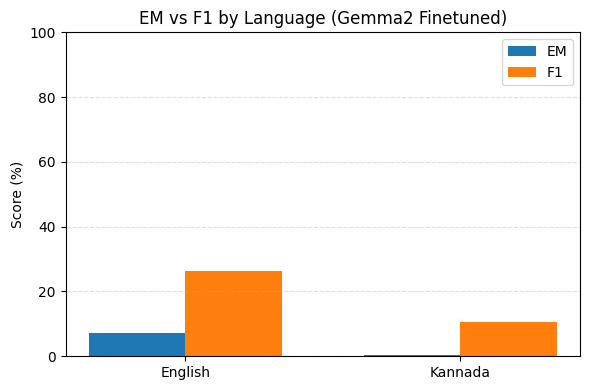

In [35]:
# EM/F1 bar chart for English vs Kannada
languages = ["English", "Kannada"]
em_scores = [eng_results["exact_match"], kan_results["exact_match"]]
f1_scores = [eng_results["f1"],          kan_results["f1"]]

x = np.arange(len(languages))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, em_scores, width, label="EM")
plt.bar(x + width/2, f1_scores, width, label="F1")

plt.xticks(x, languages)
plt.ylabel("Score (%)")
plt.title("EM vs F1 by Language (Gemma2 Finetuned)")
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [36]:
eng_answer_lengths = []
eng_f1_per_example = []

for pred, ref in zip(eng_preds, eng_refs):
    pred_text = pred["prediction_text"]
    gt_text = ref["answers"]["text"][0]

    f1 = compute_f1(pred_text, gt_text)
    length = len(gt_text.split())

    eng_f1_per_example.append(f1)
    eng_answer_lengths.append(length)

kan_answer_lengths = []
kan_f1_per_example = []

for pred, ref in zip(kan_preds, kan_refs):
    pred_text = pred["prediction_text"]
    gt_text = ref["answers"]["text"][0]

    f1 = compute_f1(pred_text, gt_text)
    length = len(gt_text.split())

    kan_f1_per_example.append(f1)
    kan_answer_lengths.append(length)


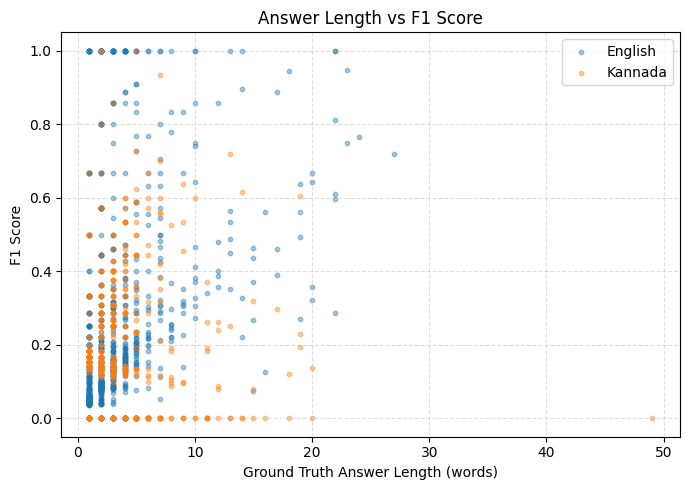

In [37]:
plt.figure(figsize=(7, 5))
plt.scatter(eng_answer_lengths, eng_f1_per_example, alpha=0.4, label="English", s=10)
plt.scatter(kan_answer_lengths, kan_f1_per_example, alpha=0.4, label="Kannada", s=10)

plt.xlabel("Ground Truth Answer Length (words)")
plt.ylabel("F1 Score")
plt.title("Answer Length vs F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
from collections import Counter

def categorize_errors(preds, refs):
    categories = []
    for pred, ref in zip(preds, refs):
        pred_text = pred["prediction_text"]
        gt_texts = ref["answers"]["text"]
        
        f1 = max(compute_f1(pred_text, t) for t in gt_texts)
        em = max(compute_exact_match(pred_text, t) for t in gt_texts)

        if em == 1.0:
            categories.append("Exact match")
        elif f1 > 0.0:
            categories.append("Partial overlap")
        else:
            categories.append("No overlap")
    return Counter(categories)

eng_cat = categorize_errors(eng_preds, eng_refs)
kan_cat = categorize_errors(kan_preds, kan_refs)

print("English error categories:", eng_cat)
print("Kannada error categories:", kan_cat)


English error categories: Counter({'Partial overlap': 894, 'Exact match': 71, 'No overlap': 35})
Kannada error categories: Counter({'No overlap': 600, 'Partial overlap': 397, 'Exact match': 3})


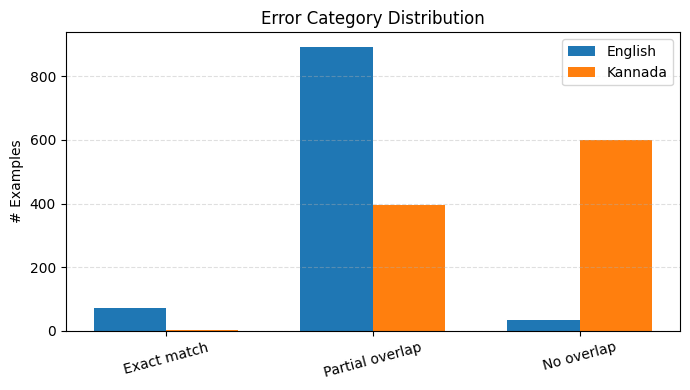

In [39]:
all_cats = ["Exact match", "Partial overlap", "No overlap"]
eng_vals = [eng_cat.get(c, 0) for c in all_cats]
kan_vals = [kan_cat.get(c, 0) for c in all_cats]

x = np.arange(len(all_cats))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, eng_vals, width, label="English")
plt.bar(x + width/2, kan_vals, width, label="Kannada")

plt.xticks(x, all_cats, rotation=15)
plt.ylabel("# Examples")
plt.title("Error Category Distribution")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


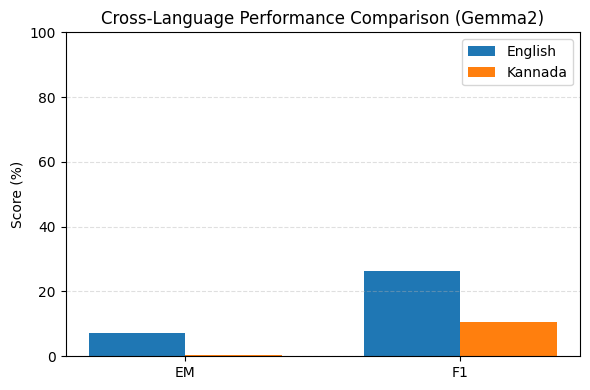

In [43]:
metrics = ["EM", "F1"]
english_scores = [eng_results["exact_match"], eng_results["f1"]]
kannada_scores = [kan_results["exact_match"], kan_results["f1"]]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, english_scores, width, label="English")
plt.bar(x + width/2, kannada_scores, width, label="Kannada")

plt.xticks(x, metrics)
plt.ylabel("Score (%)")
plt.title("Cross-Language Performance Comparison (Gemma2)")
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [44]:
import string
from collections import Counter
import time
import random

def normalize_answer(s: str) -> str:
    def remove_articles(text):
        return " ".join(
            w for w in text.split() if w.lower() not in ("a", "an", "the")
        )

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        return "".join(ch for ch in text if ch not in string.punctuation)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact_match(prediction: str, ground_truth: str) -> float:
    return float(normalize_answer(prediction) == normalize_answer(ground_truth))


def compute_f1(prediction: str, ground_truth: str) -> float:
    pred_tokens = normalize_answer(prediction).split()
    gt_tokens = normalize_answer(ground_truth).split()

    if len(pred_tokens) == 0 and len(gt_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(gt_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(gt_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gt_tokens)
    return 2 * precision * recall / (precision + recall)


def compute_squad_metrics(preds, refs):
    """
    preds: list of {"id": ..., "prediction_text": ...}
    refs:  list of {"id": ..., "answers": {"text": [...], "answer_start": [...]}}
    """
    em_scores = []
    f1_scores = []

    for p, r in zip(preds, refs):
        pred_text = p["prediction_text"]
        ref_texts = r["answers"]["text"]

        em = max(compute_exact_match(pred_text, t) for t in ref_texts)
        f1 = max(compute_f1(pred_text, t) for t in ref_texts)

        em_scores.append(em)
        f1_scores.append(f1)

    return {
        "exact_match": 100.0 * sum(em_scores) / len(em_scores),
        "f1": 100.0 * sum(f1_scores) / len(f1_scores),
    }


In [45]:
import torch

def generate_answer_gemma(
    question,
    context,
    lang="en",
    max_input_length=512,
    max_new_tokens=32,
):
    """
    Greedy decoding, short answers, caching ON → fast eval.
    """
    prompt = build_prompt(question, context, lang=lang)

    inputs = ft_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
    ).to(device)

    ft_model.config.use_cache = True

    with torch.no_grad():
        outputs = ft_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=1,        
            do_sample=False,
            early_stopping=True,
            eos_token_id=ft_tokenizer.eos_token_id,
            pad_token_id=ft_tokenizer.pad_token_id,
        )

    generated_ids = outputs[0]
    prompt_len = inputs["input_ids"].shape[1]
    answer_ids = generated_ids[prompt_len:]
    answer = ft_tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
    return answer


In [46]:
from tqdm import tqdm

def subsample_list(data, n, seed=42):
    if n is None or n >= len(data):
        return data
    random.seed(seed)
    indices = random.sample(range(len(data)), n)
    return [data[i] for i in indices]


def evaluate_gemma(
    test_data,
    lang_label="English",
    n_samples=None,       
    seed=42,
):
    """
    test_data: list of SQuAD-style dicts (id, context, question, answers)
    lang_label: "English" or "Kannada" (used only to pick lang="en"/"kn")
    n_samples: if not None, evaluate on a random subset of this size
    """
    data = subsample_list(test_data, n_samples, seed=seed)

    preds = []
    refs = []

    lang = "kn" if lang_label.lower().startswith("kan") else "en"

    start_time = time.time()
    for ex in tqdm(data, desc=f"Evaluating Gemma2 finetuned ({lang_label})"):
        pred_text = generate_answer_gemma(
            question=ex["question"],
            context=ex["context"],
            lang=lang,
        )
        preds.append({"id": ex["id"], "prediction_text": pred_text})
        refs.append({"id": ex["id"], "answers": ex["answers"]})

    elapsed = time.time() - start_time
    per_example = elapsed / len(data)

    results = compute_squad_metrics(preds, refs)

    print(f"\n{lang_label} evaluation on {len(data)} examples:")
    print(f"  Exact Match: {results['exact_match']:.2f}%")
    print(f"  F1 Score:    {results['f1']:.2f}%")
    print(f"  Total time:  {elapsed:.1f} sec ({per_example:.3f} sec/example)")

    return results, preds, refs


In [48]:
import pandas as pd

def build_question_length_df(test_data, preds, refs, lang_label="English"):
    records = []
    for ex, pred, ref in zip(test_data, preds, refs):
        question = ex["question"]
        q_len = len(question.split())
        gt_text = ref["answers"]["text"][0]
        pred_text = pred["prediction_text"]

        em = compute_exact_match(pred_text, gt_text)
        f1 = compute_f1(pred_text, gt_text)

        records.append({
            "id": ex["id"],
            "lang": lang_label,
            "question": question,
            "question_len": q_len,
            "ground_truth": gt_text,
            "prediction": pred_text,
            "em": em,
            "f1": f1,
        })
    return pd.DataFrame(records)

eng_q_df = build_question_length_df(eng_test, eng_preds, eng_refs, lang_label="English")
kan_q_df = build_question_length_df(kan_test, kan_preds, kan_refs, lang_label="Kannada")

all_q_df = pd.concat([eng_q_df, kan_q_df], ignore_index=True)
all_q_df.head()


,id,lang,question,question_len,ground_truth,prediction,em,f1
0,573257950fdd8d15006c69ee,English,What year did the global recession that follow...,14,John Brown,John Brown. Slanderous rumours of a romantic c...,0.0,0.114286
1,5706b11d0eeca41400aa0d36,English,what was a popular club in ibiza that started ...,14,"""La Reyne s'avisera""","La Reyne s'avisera"" (""the Queen will consider ...",0.0,0.285714
2,5709667eed30961900e840a1,English,What is the climate like?,5,International Festival of Arts and Ideas,International Festival of Arts and Ideas. New ...,0.0,0.255319
3,57294e7a6aef051400154c93,English,Has Bermuda's constitution ever been amended?,6,three,"three Axis Powers. Japan, Germany, and Italy.",0.0,0.250000
4,56de818dcffd8e1900b4b99c,English,What is the name of a show from Northern Irela...,16,Mughal Empire,"Mughal Empire, which at its zenith covered mod...",0.0,0.083333


In [49]:
import pandas as pd

bins = [0, 5, 10, 15, 20, 1000]
labels = ["1–5", "6–10", "11–15", "16–20", "21+"]

eng_q_df["q_len_bin"] = pd.cut(eng_q_df["question_len"], bins=bins, labels=labels, right=True)
kan_q_df["q_len_bin"] = pd.cut(kan_q_df["question_len"], bins=bins, labels=labels, right=True)

eng_grouped = eng_q_df.groupby("q_len_bin").agg(
    mean_em=("em", "mean"),
    mean_f1=("f1", "mean"),
    count=("id", "count")
).reset_index()

eng_grouped["mean_em"] *= 100
eng_grouped["mean_f1"] *= 100

kan_grouped = kan_q_df.groupby("q_len_bin").agg(
    mean_em=("em", "mean"),
    mean_f1=("f1", "mean"),
    count=("id", "count")
).reset_index()

kan_grouped["mean_em"] *= 100
kan_grouped["mean_f1"] *= 100

eng_grouped, kan_grouped


/tmp/ipython-input-2527436617.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_grouped = eng_q_df.groupby("q_len_bin").agg(
/tmp/ipython-input-2527436617.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kan_grouped = kan_q_df.groupby("q_len_bin").agg(


(  q_len_bin    mean_em    mean_f1  count
 0       1–5   3.174603  24.817422     63
 1      6–10   9.340659  28.236256    546
 2     11–15   4.075235  23.454134    319
 3     16–20   4.838710  24.665542     62
 4       21+  20.000000  30.682483     10,
   q_len_bin   mean_em    mean_f1  count
 0       1–5  0.000000   9.693712    286
 1      6–10  0.483092  10.501396    621
 2     11–15  0.000000  12.265341     86
 3     16–20  0.000000  18.490028      6
 4       21+  0.000000   0.000000      1)

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_by_q_len(grouped, title):
    x = np.arange(len(grouped))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, grouped["mean_em"], width, label="Exact Match (EM)")
    plt.bar(x + width/2, grouped["mean_f1"], width, label="F1 Score")

    plt.xticks(x, grouped["q_len_bin"].astype(str))
    plt.xlabel("Question Length (words)")
    plt.ylabel("Score (%)")
    plt.title(title)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


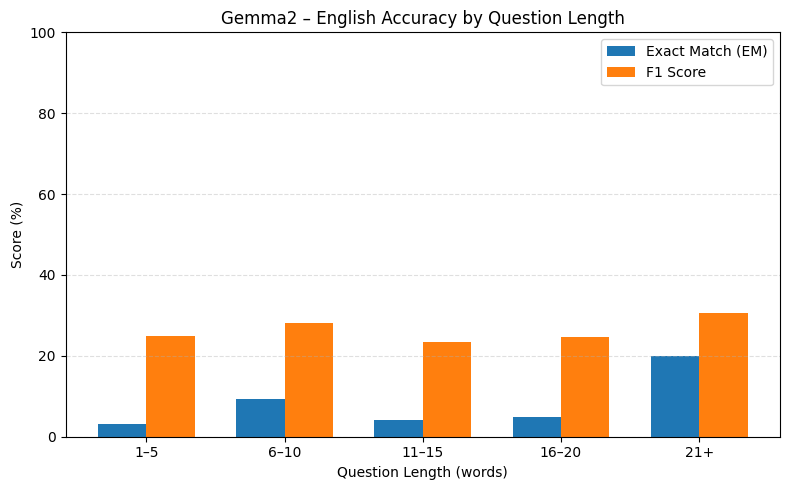

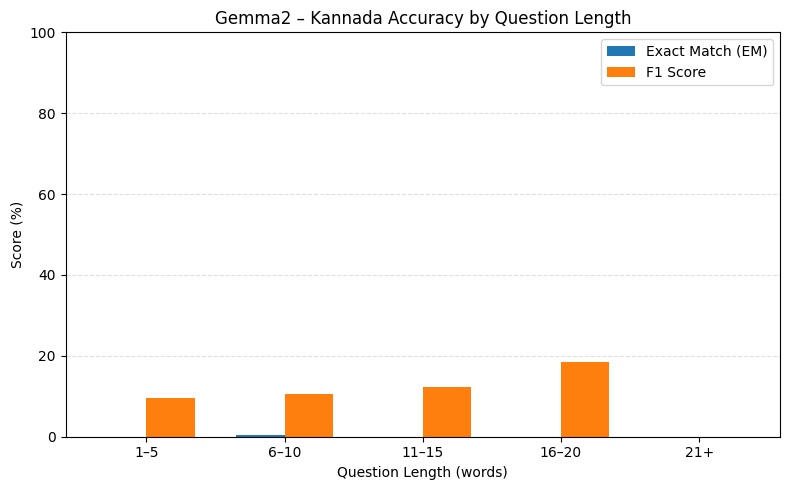

In [51]:
plot_accuracy_by_q_len(
    eng_grouped,
    "Gemma2 – English Accuracy by Question Length"
)

plot_accuracy_by_q_len(
    kan_grouped,
    "Gemma2 – Kannada Accuracy by Question Length"
)


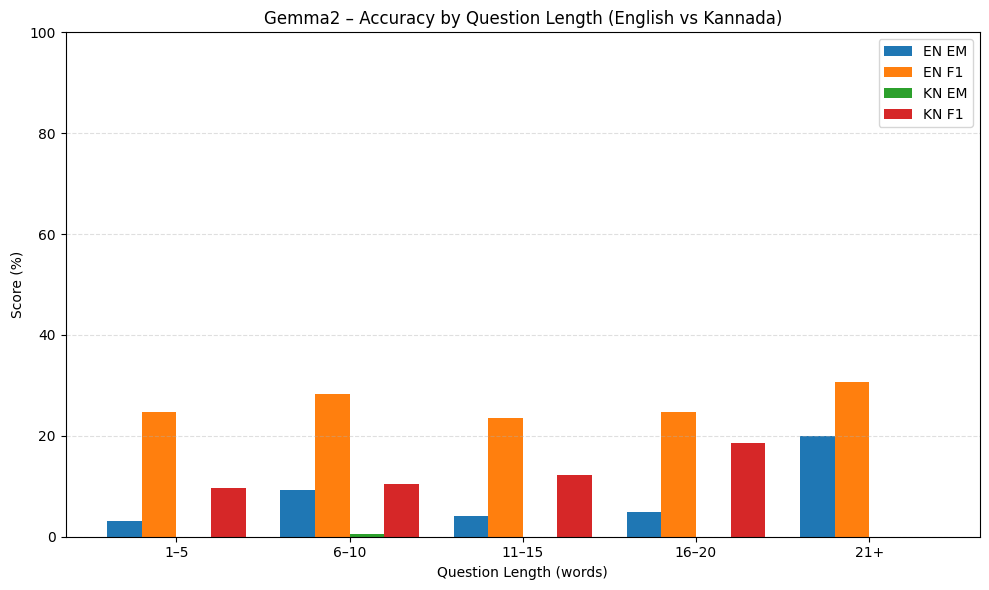

In [52]:
def plot_combined_accuracy(eng_grouped, kan_grouped):
    labels = eng_grouped["q_len_bin"].astype(str)
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))

    # English
    plt.bar(x - width*1.5, eng_grouped["mean_em"], width, label="EN EM")
    plt.bar(x - width/2,  eng_grouped["mean_f1"], width, label="EN F1")

    # Kannada
    plt.bar(x + width/2,  kan_grouped["mean_em"], width, label="KN EM")
    plt.bar(x + width*1.5, kan_grouped["mean_f1"], width, label="KN F1")

    plt.xticks(x, labels)
    plt.xlabel("Question Length (words)")
    plt.ylabel("Score (%)")
    plt.title("Gemma2 – Accuracy by Question Length (English vs Kannada)")
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_combined_accuracy(eng_grouped, kan_grouped)
